# **<center><span style= "color:#43C6DB;">Kaggle competition Notebook</span></center>**

- Author: Sheraz Ahmed
- LinkedIn: https://www.linkedin.com/in/sheraz-ahmed-511965200/
- Github: https://github.com/sherazAhmed-ipynb


## ***<span style= "color:#3EA99F;">Survival rate prediction with neural network in tensorflow </span>***

In [19]:
# imports the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, r2_score, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## ***<span style= "color:#6495ED;">Data Preprocessing </span>***

In [4]:
# load the dataset
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/gender_submission.csv')

In [5]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [8]:
# lets explore the data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [12]:
# check for mssing values
(df_train.isnull().sum() / len(df_train) * 100).sort_values(ascending=False)

Cabin          77.104377
Age            19.865320
Embarked        0.224467
PassengerId     0.000000
Name            0.000000
Pclass          0.000000
Survived        0.000000
Sex             0.000000
Parch           0.000000
SibSp           0.000000
Fare            0.000000
Ticket          0.000000
dtype: float64

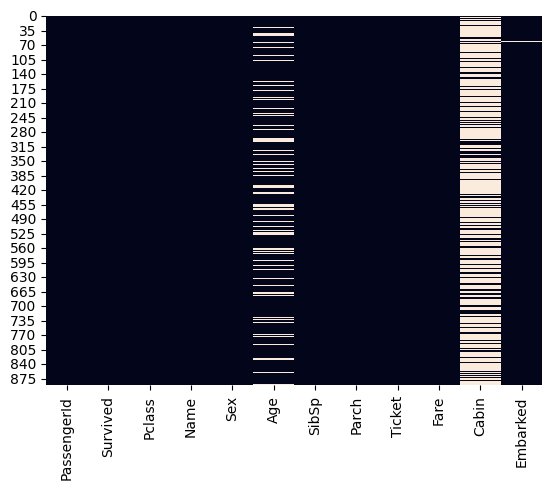

In [13]:
# plot the missing values 
sns.heatmap(df_train.isnull(), cbar=False)
plt.show()

In [14]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [17]:
# changing the df_train to df for fucntionality constraints
df = df_train.copy()

#### ***<span style= "color:#6495ED;">Function to impute missing values</span>***

In [21]:

categorical_cols = ['Cabin', 'Embarked']
bool_cols = []
numeric_cols = ['Age']

missing_data_cols = df.isnull().sum()[df.isnull().sum() > 0].index.tolist()

# define the function to impute the missing values in thal column

def impute_categorical_missing_data(passed_col):
    
    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    if passed_col in bool_cols:
        y = label_encoder.fit_transform(y)
        
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_classifier = RandomForestClassifier()

    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)

    print("The feature '"+ passed_col+ "' has been imputed with", round((acc_score * 100), 2), "accuracy\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_classifier.predict(X)
        if passed_col in bool_cols:
            df_null[passed_col] = df_null[passed_col].map({0: False, 1: True})
        else:
            pass
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

def impute_continuous_missing_data(passed_col):
    
    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])
    
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_regressor = RandomForestRegressor()

    rf_regressor.fit(X_train, y_train)

    y_pred = rf_regressor.predict(X_test)

    print("MAE =", mean_absolute_error(y_test, y_pred), "\n")
    # print("RMSE =", mean_squared_error(y_test, y_pred, squared=False), "\n")
    print("R2 =", r2_score(y_test, y_pred), "\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_regressor.predict(X)
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

# remove warning
import warnings
warnings.filterwarnings('ignore')

# impute missing values using our functions
for col in missing_data_cols:
    print("Missing Values", col, ":", str(round((df[col].isnull().sum() / len(df)) * 100, 2))+"%")
    if col in categorical_cols:
        df[col] = impute_categorical_missing_data(col)
    elif col in numeric_cols:
        df[col] = impute_continuous_missing_data(col)
    else:
        pass

(df.isnull().sum() / len(df) * 100 ).sort_values(ascending=False)

Missing Values Age : 19.87%
MAE = 9.335495804195803 

R2 = 0.2634236335716472 

Missing Values Cabin : 77.1%
The feature 'Cabin' has been imputed with 31.71 accuracy

Missing Values Embarked : 0.22%
The feature 'Embarked' has been imputed with 89.33 accuracy



PassengerId    0.0
Survived       0.0
Pclass         0.0
Name           0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Ticket         0.0
Fare           0.0
Cabin          0.0
Embarked       0.0
dtype: float64

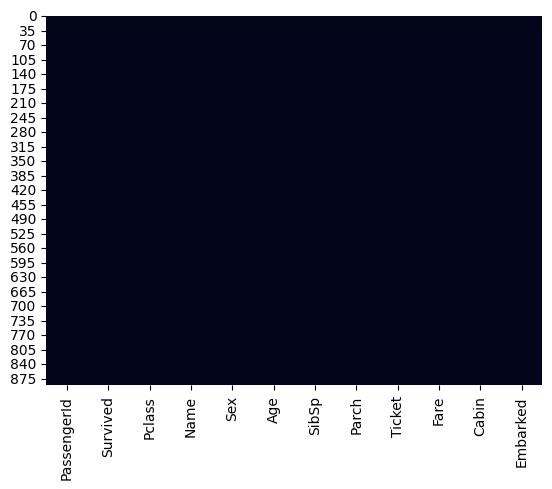

In [23]:
# plot missing values
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [ ]:
# split the data into X and y
X = df.drop(['Survived', 'Name'], axis=1)
y = df['Survived']

# encode the data
label_encoder = LabelEncoder()

for col in X.columns:
    if X[col].dtype == 'object' or X[col].dtype == 'category':
        X[col] = label_encoder.fit_transform(X[col])
    else:
        pass
    
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)